# Linear Regression, kNN Regression, and Inference

[Resource](https://harvard-iacs.github.io/2018-CS109A/lectures/lecture-4/)

# Part 1: Load Basic Python Modules

In [1]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_adv = pd.read_csv("../data/Advertising.csv")

Now get a subset of the data:

In [3]:
data_x = df_adv.TV[5:13]
data_y = df_adv.sales[5:13]

In [4]:
data_x

5       8.7
6      57.5
7     120.2
8       8.6
9     199.8
10     66.1
11    214.7
12     23.8
Name: TV, dtype: float64

# Part 3: Sort the Data

We need to sort the data in order to apply the KNN algorithm.

In [5]:
idx = np.argsort(data_x).values # Get indices ordered from lowest to highest values
idx

array([3, 0, 7, 1, 5, 2, 4, 6])

Remember that the above output are the indices from `data_x`, not the indices from `df_adv`.

In [6]:
# Get the actual data in the order from above
data_x = data_x.iloc[idx]
data_y = data_y.iloc[idx]

In [7]:
data_x

8       8.6
5       8.7
12     23.8
6      57.5
10     66.1
7     120.2
9     199.8
11    214.7
Name: TV, dtype: float64

In [8]:
data_y

8      4.8
5      7.2
12     9.2
6     11.8
10     8.6
7     13.2
9     10.6
11    17.4
Name: sales, dtype: float64

Now here's a function that finds the index of the nearest neighbor and returns the value of the nearest neighbor. Note that this is just for k=1 and the distance function is simply the absolute value.

In [9]:
def find_nearest(array, value):
    idx = (np.abs(array-value)).idxmin()
    return idx, array[idx]

Note that we've used the `idxmin` method in our function. This is because `array` is a pandas dataframe and `idxmin()` is designed to work with pandas dataframes. If we are working with a numpy array then the appropriate method would be `argmin()`.

In [10]:
# Create some artificial x-values
x = np.linspace(np.min(data_x), np.max(data_x))

# Initialize the y-values to zero
y = np.zeros((len(x)))

Apply the KNN algorithm. Try to predict the y-value at a given x-value.

Note: You may have tried to use the `range` method in your code before. Enumerate is far better in this case. Look up `range` vs. `enumerate` and you will see why.

In [11]:
for i, xi in enumerate(x):
    y[i] = data_y[find_nearest(data_x, xi)[0]]

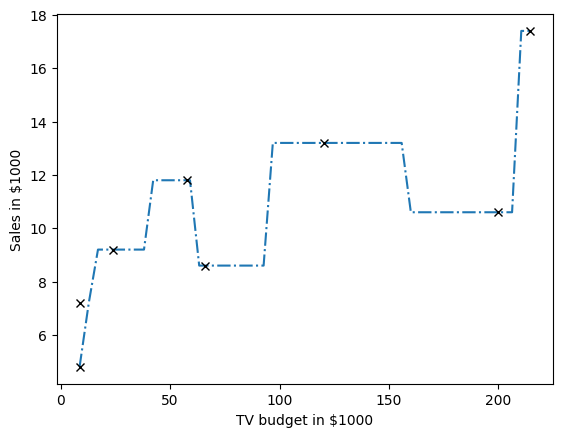

In [12]:
# Plot the solution
plt.plot(x, y, "-.")

# Plot the original data using black x's
plt.plot(df_adv.TV[5:13], df_adv.sales[5:13], "kx")
plt.title('')
plt.xlabel("TV budget in $1000")
plt.ylabel("Sales in $1000");

Now let's move onto the actual example.

# Prediction using kNN and Linear Regression

[Resource](https://harvard-iacs.github.io/2018-CS109A/sections/section-2/solutions/)

For this section, our goal is to get you familiarized with k-Nearest Neighbors and Linear. These methods find powerful applications in all walks of life and are centered around prediction.

Specifically, we will:

1. Review Basic Python Data Structures
2. Import Data and Manipulates Rows and Columns
3. Load in the Bikeshare dataset which is split into a training and testing dataset
3. Do some basic exploratory analysis of the dataset and go through a scatterplot
5. Write out the algorithm for kNN WITH AND WITHOUT using the sklearn package
6. Learn to use the sklearn package for Linear Regression.
7. What is and how to extract information about Confidence Intervals.

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Regression imports
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
import statsmodels.api as sm

# Metrics, performance evaluation, and helpful functions
from sklearn import metrics, datasets
from collections import Counter
from sklearn.model_selection import train_test_split

# Aesthetic settings
from IPython.display import display
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)

# Load in the Bikeshare dataset and perform EDA

The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.

Here's an overview of the data:
* season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
* month (1 through 12, with 1 denoting Jan)
* holiday (1 = the day is a holiday, 0 = otherwise)
* day_of_week (0 through 6, with 0 denoting Sunday)
* workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
* weather
    1. Clear, Few clouds, Partly cloudy, Partly cloudy
    2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp (temperature in Celsius)
* atemp (apparent temperature, or relative outdoor temperature, in Celsius)
* humidity (relative humidity)
* windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.

In [14]:
bikeshare = pd.read_csv("../data/bikeshare.csv")
del bikeshare["Unnamed: 0"]
print("Length of Dataset:", len(bikeshare))
bikeshare.head()

Length of Dataset: 731


,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


In [15]:
bikeshare.describe()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,6.519836,0.028728,2.997264,0.683995,1.395349,16.229822,18.885089,62.789406,0.190486,4552.354309
std,1.110807,3.451913,0.167155,2.004787,0.465233,0.544894,11.531101,10.278475,14.242910,0.077498,2021.971365
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-11.000000,-6.000000,0.000000,0.022392,22.000000
25%,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,6.000000,10.000000,52.000000,0.134950,3116.000000
50%,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,16.000000,20.000000,62.666700,0.180975,4575.000000
75%,3.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.000000,27.000000,73.020850,0.233214,6048.000000
max,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,39.000000,42.000000,97.250000,0.507463,10045.000000


We can also use the `groupby` function to look at mean stats aggregated by month:

In [16]:
bikeshare.groupby("month").mean()

,season,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
month,,,,,,,,,,
1.0,1.000000,0.048387,2.870968,0.645161,1.419355,-0.080645,4.145161,58.582827,0.206303,2498.306452
2.0,1.000000,0.035088,3.000000,0.684211,1.368421,3.912281,7.807018,56.746468,0.215684,2824.315789
3.0,1.354839,0.000000,3.096774,0.725806,1.451613,9.580645,13.080645,58.847503,0.222699,3822.241935
4.0,2.000000,0.033333,3.000000,0.666667,1.416667,14.583333,17.783333,58.806312,0.234482,4348.600000
5.0,2.000000,0.032258,2.903226,0.693548,1.403226,22.532258,24.661290,68.895831,0.182989,5268.790323
6.0,2.333333,0.000000,3.100000,0.716667,1.233333,28.150000,29.216667,57.580552,0.185420,5547.033333
7.0,3.000000,0.032258,2.935484,0.661290,1.193548,32.580645,33.338710,59.787632,0.166059,5563.677419
8.0,3.000000,0.000000,3.000000,0.741935,1.306452,29.629032,30.096774,63.773010,0.172918,5584.887097
9.0,3.266667,0.033333,3.050000,0.666667,1.500000,23.850000,25.466667,71.471437,0.165945,5653.316667


Let's plot the variation of the count with month. Is there a seasonal change?

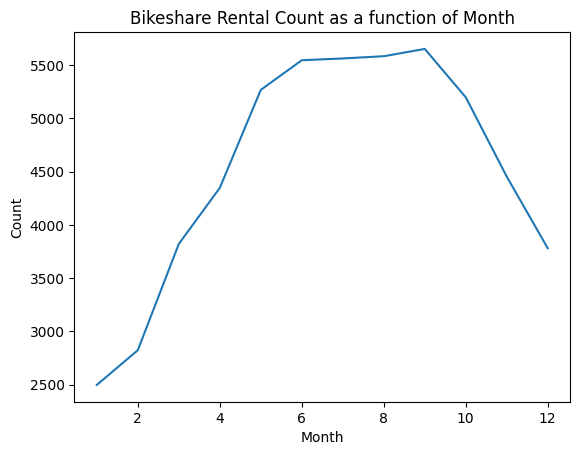

In [17]:
plt.plot(bikeshare.groupby("month").mean()["count"])
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Bikeshare Rental Count as a function of Month")
plt.show()

What is temp, a_temp, is there a difference?

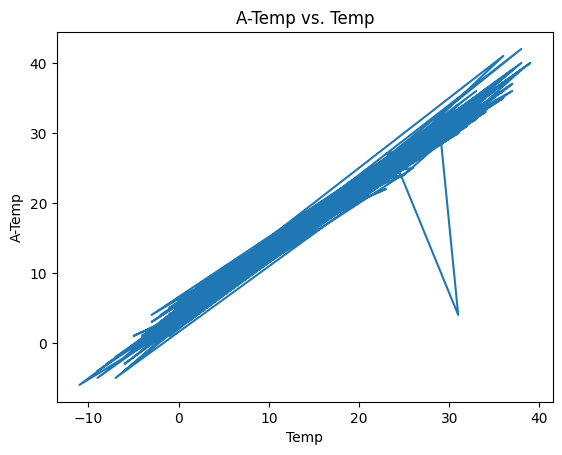

In [18]:
plt.plot(bikeshare["temp"], bikeshare["atemp"])
plt.xlabel("Temp")
plt.ylabel("A-Temp")
plt.title("A-Temp vs. Temp")
plt.show()

**What did we do wrong here? Why does the plot look like this?**

Sorting! Whenever your plot makes zig-zag changes across the scale, it's because `matplotlib` is trying to connect the points sequentially from the top (using a line plot) and skipping across the scale when x of i+1 if lower than x of i. So let's sort.

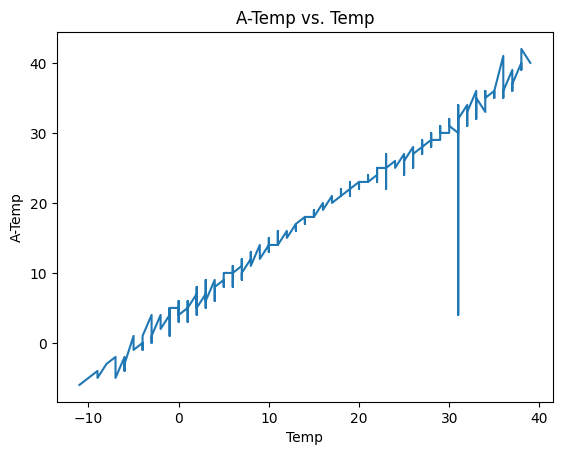

In [19]:
new = bikeshare.sort_values(['temp'])
plt.plot(new['temp'], new["atemp"])
plt.xlabel("Temp")
plt.ylabel("A-Temp")
plt.title("A-Temp vs. Temp")
plt.show()

**It still looks weird, why?**

Let's have a closer look at the dataframe:

In [20]:
new.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
176,1.0,1.0,0.0,6.0,0.0,1.0,-11.0,-6.0,40.0000,0.171970,981.0
367,1.0,1.0,0.0,1.0,1.0,1.0,-9.0,-4.0,49.1739,0.158330,1416.0
265,1.0,1.0,0.0,0.0,0.0,1.0,-9.0,-5.0,43.6522,0.246600,986.0
346,1.0,1.0,0.0,3.0,1.0,2.0,-8.0,-3.0,41.4583,0.184700,2368.0
612,1.0,2.0,0.0,3.0,1.0,2.0,-7.0,-2.0,49.4783,0.188839,1605.0


There are multiple `atemp` values for each `temp` value, which if not sorted will bounce around at the same x-value. Thus, we need to sort both axes simultaneously.

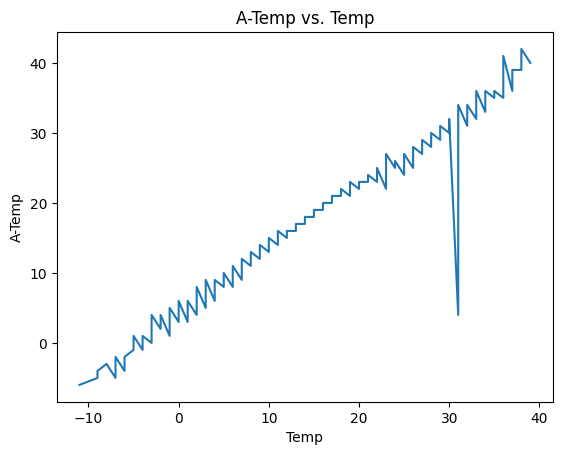

In [21]:
new = bikeshare.sort_values(["temp", "atemp"])
plt.plot(new["temp"], new["atemp"])
plt.xlabel("Temp")
plt.ylabel("A-Temp")
plt.title("A-Temp vs. Temp")
plt.show()

By plotting efficiently, we've found an anomaly we would've otherwise overlooked. **It looks like there is a problem with the data around temp greater than 30 and atemp less than 10**.

In [22]:
(bikeshare[(bikeshare['temp']>30) & (bikeshare['atemp']<10)])

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
188,3.0,8.0,0.0,5.0,1.0,1.0,31.0,4.0,57.0833,0.231354,7148.0


Anomaly! `atemp` and `temp` are usually linearly related except at this one datapoint. Now, we get to make a judgement call as to whether we should keep the data point. We'll come back to this question after the lecture on Missing Data and Imputation. Worth a thought though.

In [23]:
bikeshare = bikeshare.drop([188])
display(bikeshare[(bikeshare["temp"] > 30) & (bikeshare["atemp"] < 10)])

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count


## Normalize

In general, it's good practice to normalize data before proceeding. As such, we can create the following functions:

In [24]:
def normalize(x):
    num = x - np.min(x)
    denom = np.max(x) - np.min(x)
    return (num/denom)

bikeshare_norm = normalize(bikeshare)
bikeshare_norm.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,0.001293,0.001591,0.001094,0.001293,0.001193,0.001293,0.003481,0.003679,0.008710,0.001106,0.605012
1,0.001492,0.002287,0.001094,0.001293,0.001193,0.001193,0.002586,0.002983,0.008391,0.001111,0.658015
2,0.001293,0.001691,0.001094,0.001492,0.001193,0.001193,0.003679,0.003878,0.006758,0.001119,0.733294
3,0.001492,0.002287,0.001094,0.001094,0.001094,0.001193,0.001094,0.001492,0.006924,0.001111,0.242840
4,0.001392,0.001989,0.001094,0.001392,0.001193,0.001392,0.003381,0.003381,0.010214,0.001104,0.199582


In [25]:
bikeshare_norm.describe()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.001342,0.001742,0.001097,0.001392,0.001162,0.001233,0.002706,0.002974,0.007339,0.001113,0.453441
std,0.000111,0.000343,0.000017,0.000199,0.000046,0.000054,0.001146,0.001021,0.001417,0.000008,0.200981
min,0.001193,0.001193,0.001094,0.001094,0.001094,0.001193,0.000000,0.000497,0.001094,0.001096,0.003282
25%,0.001293,0.001492,0.001094,0.001193,0.001094,0.001193,0.001691,0.002088,0.006265,0.001107,0.310909
50%,0.001342,0.001790,0.001094,0.001392,0.001193,0.001193,0.002685,0.003083,0.007330,0.001112,0.455798
75%,0.001392,0.002088,0.001094,0.001591,0.001193,0.001293,0.003679,0.003779,0.008356,0.001117,0.602029
max,0.001492,0.002287,0.001193,0.001691,0.001193,0.001392,0.004972,0.005270,0.010765,0.001144,1.000000


In [26]:
def split_data(data):
    length = len(data)
    split = 0.7

    # Set random seed for shuffling
    np.random.seed(9001)

    # Generate a mask with a X:Y split
    mask = np.random.rand(length) < split
    
    data_train = data[mask]
    data_test = data[~mask]

    return data_train, data_test

In [27]:
# Adapt the normalization function to take column names as input

def normalize_cols(x, columns):
    for i in columns: x[i] = normalize(x[i])
    return x

bikeshare_norm2 = normalize_cols(bikeshare, bikeshare.columns)

In [28]:
bikeshare_norm2.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,0.333333,0.363636,0.0,0.333333,1.0,0.5,0.70,0.666667,0.787489,0.197445,0.603711
1,1.000000,1.000000,0.0,0.333333,1.0,0.0,0.52,0.520833,0.754499,0.312814,0.656889
2,0.333333,0.454545,0.0,0.666667,1.0,0.0,0.74,0.708333,0.585689,0.476922,0.732415
3,1.000000,1.000000,0.0,0.000000,0.0,0.0,0.22,0.208333,0.602828,0.303846,0.240347
4,0.666667,0.727273,0.0,0.500000,1.0,1.0,0.68,0.604167,0.943016,0.153852,0.196947


In [29]:
bikeshare.describe

<bound method NDFrame.describe of        season     month  holiday  day_of_week  workingday  weather  temp     atemp  humidity  windspeed     count
0    0.333333  0.363636      0.0     0.333333         1.0      0.5  0.70  0.666667  0.787489   0.197445  0.603711
1    1.000000  1.000000      0.0     0.333333         1.0      0.0  0.52  0.520833  0.754499   0.312814  0.656889
2    0.333333  0.454545      0.0     0.666667         1.0      0.0  0.74  0.708333  0.585689   0.476922  0.732415
3    1.000000  1.000000      0.0     0.000000         0.0      0.0  0.22  0.208333  0.602828   0.303846  0.240347
4    0.666667  0.727273      0.0     0.500000         1.0      1.0  0.68  0.604167  0.943016   0.153852  0.196947
5    0.333333  0.363636      0.0     0.333333         1.0      0.5  0.70  0.666667  0.716795   0.660264  0.441884
6    1.000000  0.909091      0.0     0.666667         1.0      0.0  0.36  0.354167  0.342908   0.670918  0.528085
7    0.333333  0.454545      0.0     0.333333         

# Broadcasting

From [Numpy's documentation](https://numpy.org/doc/stable/user/basics.broadcasting.html):

The term broadcasting describes how NumPy treats arrays with different shapes during arithmetic operations. Subject to certain constraints, the smaller array is “broadcast” across the larger array so that they have compatible shapes. Broadcasting provides a means of vectorizing array operations so that looping occurs in C instead of Python. 

# Choose one predictor

In [30]:
bikeshare.columns
bikeshare = bikeshare[["temp", "count"]]
bikeshare.head()

,temp,count
0,0.70,0.603711
1,0.52,0.656889
2,0.74,0.732415
3,0.22,0.240347
4,0.68,0.196947


# Split the data into a train and test set

Now that we have an idea of what the data looks like, we would like to predict the count. Therefore, we will be breaking up the data into a train and test set.

Let's first create a function that will randomly split the data up into a 70-30 split.

In [31]:
def split_data(data):
    length = len(data)
    split = 0.7
    np.random.seed(9001)
    mask = np.random.rand(length) < split

    data_train = data[mask]
    data_test = data[~mask]

    return data_train, data_test


In [32]:
train_data, test_data = split_data(bikeshare)
len(train_data), len(test_data)

(507, 223)

Now let's check that the ratio between the train and test data is correct:

In [33]:
len(test_data) / (len(test_data) + len(train_data))

0.30547945205479454

In [34]:
test_data.shape[0] / (test_data.shape[0] + train_data.shape[0])

0.30547945205479454

# Old vs. New Indices

Here I think the professor is also just showing the difference between `.loc` and `.iloc`.

In [35]:
train_data.head()

,temp,count
0,0.70,0.603711
3,0.22,0.240347
5,0.70,0.441884
6,0.36,0.528085
9,0.82,0.730819


In [36]:
train_data.iloc[:5]

,temp,count
0,0.70,0.603711
3,0.22,0.240347
5,0.70,0.441884
6,0.36,0.528085
9,0.82,0.730819


In [37]:
train_data.loc[3:9]

,temp,count
3,0.22,0.240347
5,0.70,0.441884
6,0.36,0.528085
9,0.82,0.730819


In [38]:
train_data.iloc[3:9]

,temp,count
6,0.36,0.528085
9,0.82,0.730819
12,0.26,0.218298
13,0.66,0.734511
14,0.46,0.434900
15,0.68,0.818617


# Splitting data using `train_test_split`

In [39]:
train_data, test_data = train_test_split(bikeshare, test_size=0.3, random_state=13)
print(len(train_data), len(test_data))

511 219


In [40]:
train_data.shape[0] / (train_data.shape[0] + test_data.shape[0])

0.7

# Implementing the kNN Algorithm by hand:

To really understand how the kNN algorithm works, it helps to go through the algorithm line by line in code (God, what an amazing learning resource. I'm absolutely loving this.)

In [41]:
def knn_algorithm(train, test, k):
    predictions = []

    train_x = train["temp"]
    train_y = train["count"]
    test_x = test["temp"]
    test_y = test["count"]

    for i, ele in enumerate(test_x):
        # For each test point, store the distance between all training points and test points
        distances = pd.DataFrame((train_x.values - ele)**2, index = train.index)
        distances.columns = ["dist"]

        # Sort the distances to training points (in ascending order) and take first k points
        nearest_k = distances.sort_values(by="dist").iloc[:k]

        # For simplicity, we omitted the square rooting of the Euclidean distance
        # because the square root function preserves order.

        # Take the mean of the y-values of training set corresponding to the nearest k points
        k_mean = train_y[nearest_k.index].mean()

        # Add on the mean to our predicted y-value list
        predictions.append(k_mean)

    # Create a dataframe with the x-values from test and predicted y-values
    predict = test.copy()
    predict["predicted_count"] = pd.Series(predictions, index=test.index)

    return predict

Now we run the algorithm on our dataset with k = 5:

In [42]:
k = 5
predicted_knn = knn_algorithm(train_data, test_data, k)
predicted_knn.head()

,temp,count,predicted_count
114,0.82,0.464432,0.605527
261,0.40,0.218198,0.370328
58,0.90,0.578769,0.574439
295,0.72,0.476205,0.558116
512,0.30,0.151053,0.356261


We want to have a way to evaluate our predictions from the kNN algorithm with k = 5. One way is to compute the R2 coefficient. Let's create a function for that:

In [43]:
def evaluate(predicted, true):
    squared_error = (predicted["predicted_count"] - true["count"])**2

    # MSE
    error_var = squared_error.sum()
    sample_var = ((true["count"] - true["count"].mean())**2).sum()
    r = (1 - (error_var / sample_var))

    return r

Then let's apply this function to our predictions:

In [44]:
print("Length of Test Data:",len(test_data))
print("R^2 Score of kNN - test:", evaluate(predicted_knn, test_data))

Length of Test Data: 219
R^2 Score of kNN - test: 0.15852383520023738


In [45]:
predicted_knn_train = knn_algorithm(train_data, train_data, k)
print("R^2 Score of kNN - train:", evaluate(predicted_knn_train, train_data))

R^2 Score of kNN - train: 0.3118859504906759


We see that the coefficient for the Nearest Neighbors implementation with k=5
 is R2=0.134
, which should more or less match what we get with the sklearn package.

# Using sklearn to implement kNN

We will now use the sklearn package to implement kNN. Then, we can fit the model and use various metrics to assess our accuracy.

## General sklearn model fitting code-structure

(This is gonna come in handy for your own implementations)

```python
x_train, y_train = training_data.drop("Response_Variable", axis=1), training_data["Response_Variable]
x_test, y_test = test_data.drop("Response_Variable), test_data["Response_Variable"]

# Define the model
model = sklearn_model_name(hyper_parameter1 = value1, hyperparameter2 = value2)

# Fit the model
model.fit(x_train, y_train)

# Get prediction
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# Evaluate the model
r2_train = model.score(y_train, y_pred_train)
r2_test = model.score(y_test, y_pred_test)

# Print results
print("Score for Modes (Training):", r2_train)
print("Score for Modes (Testing):", r2_test)
```

* Every model has a list of hyperparameters that can be set using sklearn for the specific problem. In practice it's advisable to cross-validate a list of values to find best model fit.
* `model.fit` calculates the parameters of your model corresponding to the training data and hyperparameters you provided.
* `model.predict(X)` is the standard method called to make the model predict values for a specific X. Depending on if you feed x_train or x_test, you will get a y_prediction_train or y_prediction_test respectively.
* Evaluation of model can vary according to the task at hand i.e. Regression or Classification. For Regression, R2
 Score is standard while for Classification, Accuracy (%) is standard.

In [46]:
k = 100

# First, we create the classifier object:
neighbors = KNeighborsRegressor(n_neighbors=k)

# Then, we fit the model using x_train as training data and y_train as target values
neighbors.fit(train_data[["temp"]], train_data["count"])

# Retrieve our predictions
prediction_knn = neighbors.predict(test_data[["temp"]])

# Retrieve accuracy measurements
r2_train = neighbors.score(train_data[["temp"]], train_data["count"])
r2_test = neighbors.score(test_data[["temp"]], test_data[["count"]])

print("Length of Test Data:", len(test_data['count']))
print("R^2 Score of kNN on test set:", r2_test)
print("R^2 Score of kNN on training set:", r2_train)

Length of Test Data: 219
R^2 Score of kNN on test set: 0.34862270656212724
R^2 Score of kNN on training set: 0.27997168384806426


Now time for some plotting:

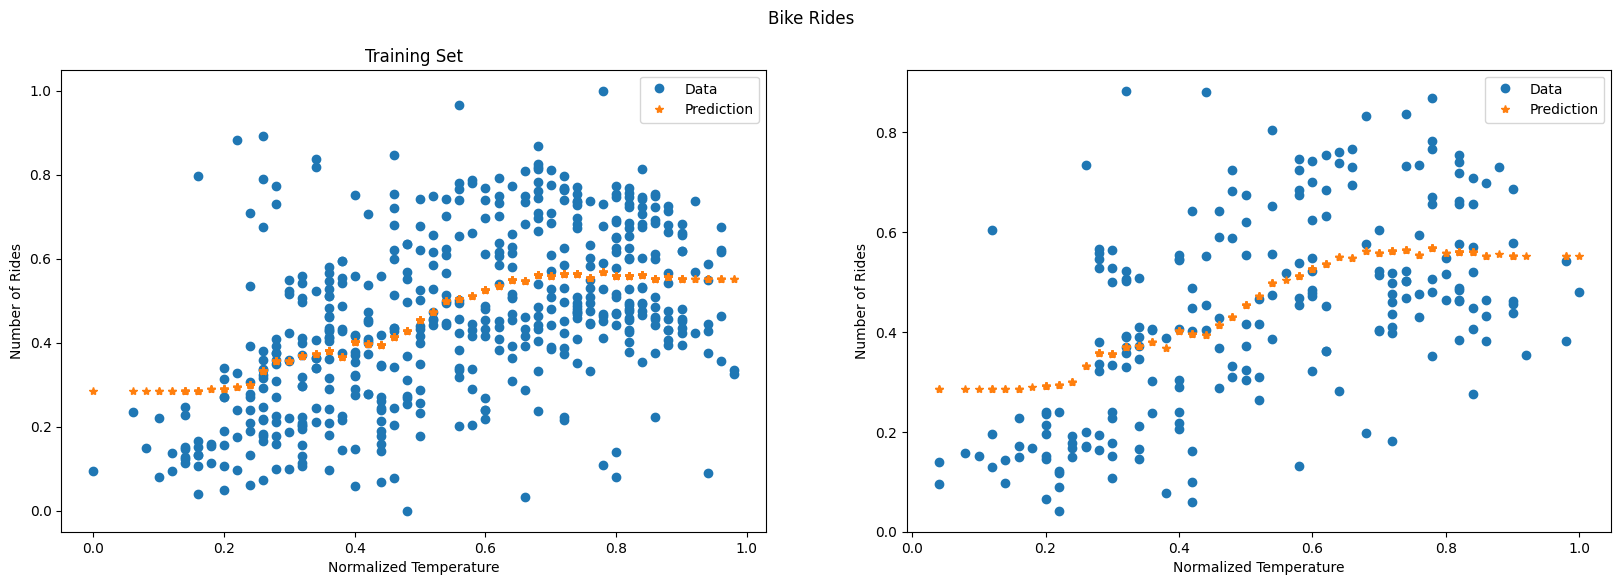

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
axes[0].plot(train_data["temp"], train_data["count"], "o", label="Data")
axes[0].plot(train_data["temp"], neighbors.predict(train_data[["temp"]]), "*", label="Prediction")
axes[0].set_xlabel("Normalized Temperature")
axes[0].set_ylabel("Number of Rides")
axes[0].set_title("Training Set")
axes[0].legend()

axes[1].plot(test_data["temp"], test_data["count"], "o", label="Data")
axes[1].plot(test_data["temp"], prediction_knn, "*", label="Prediction")
axes[1].set_xlabel("Normalized Temperature")
axes[1].set_ylabel("Number of Rides")
axes[1].set_label("Test Set")
axes[1].legend()

fig.suptitle("Bike Rides");

# Linear Regression

We just went over the kNN prediction method. Now, we will fit the same data, but Linear Regression. We will use a the same training/testing dataset as before and create our linear regression objects.

In [48]:
x_train, y_train = train_data.drop(["count"], axis=1), train_data["count"]
x_test, y_test = test_data.drop(["count"], axis=1), test_data["count"]

# Add a constant (remember: scikit automatically includes a constant, not statsmodels)
x_train_ca = sm.add_constant(x_train)
x_test_ca = sm.add_constant(x_test)

StatsModels use a Y followed by X structure while feeding data in contrast to sklearn that uses X followed by Y.

In [49]:
model = sm.OLS(y_train, x_train_ca)
results = model.fit()
print(results.params)

const    0.215898
temp     0.436177
dtype: float64


Now we will compute metrics that can be used to assess fit.

In [50]:
# NOTICE THAT WE ARE USING THE TEST SET
print("R^2 Score for Linear Regression (Training):", metrics.r2_score(y_train, results.predict(x_train_ca)))
print("R^2 Score for Linear Regression (Testing) :", metrics.r2_score(y_test, results.predict(x_test_ca)))

R^2 Score for Linear Regression (Training): 0.24497472895258843
R^2 Score for Linear Regression (Testing) : 0.3075269058033856


In [51]:
# Find the squared error
y_pred_train = results.predict(x_train_ca)
squared_error_train = (y_pred_train - y_train)**2

# Find the MSE
error_var_train = squared_error_train.mean() # Just so you don't get confused, `var` is for "variable", not "variance"
sample_var_train = ((y_train - y_train.mean())**2).mean()

y_pred_test = results.predict(x_test_ca)
squared_error_test = (y_pred_test - y_test)

# Finding the MSE
error_var_test = squared_error_test.mean()
sample_var_test = ((y_test - y_test.mean())*2).mean()

print(error_var_train, sample_var_train, 1 - error_var_train/sample_var_train)
print(error_var_test, sample_var_test, 1 - error_var_test/sample_var_test)

0.030718736215822523 0.04068570602041948 0.24497472895258843
0.005402422634548588 6.94523079331719e-17 -77786077890267.02


In [52]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     165.1
Date:                Thu, 27 Nov 2025   Prob (F-statistic):           6.20e-33
Time:                        12:05:50   Log-Likelihood:                 164.80
No. Observations:                 511   AIC:                            -325.6
Df Residuals:                     509   BIC:                            -317.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2159      0.020     10.594      0.000       0.176       0.256
temp           0.4362      0.034     12.851      0.000       0.369       0.503
==============================================================================
Omnibus:                        9.998   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.020
Skew:                           0.320   Prob(JB):                      0.00667
Kurtosis:                       3.247   Cond. No.                         5.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Confidence Intervals

In data science, a confidence interval is a type of interval estimate, computed from the statistics of the observed data, that might contain the true value of an unknown population parameter. Simply speaking, a confidence interval is a range of values we are fairly sure our true value lies in.

It's important to remind ourselves here that **confidence intervals belong to a parameter and ot a statistic**. Thus, they represent the window in which the true value exists for the entire population when all we have is a sample.

## Example

We measure the heights of 40 randomly chosen men, and get a mean height of 175cm, we also know the standard deviation of men's heights is 20cm. The 95% Confidence Interval is thus: 175cm ± 6.2cm. This says the true mean of ALL men (if we could measure all their heights) is likely to be between 168.8cm and 181.2cm.

But it might not be! The "95%" says that 95% of experiments like we just did will include the true mean, but 5% won't. So there is a 1-in-20 chance (5%) that our Confidence Interval does NOT include the true mean.

To get Confidence Intervals using StatsModels:

In [53]:
thresh = 0.05
intervals = results.conf_int(alpha=thresh)
print(intervals)
intervals = intervals.rename(index=str, columns={0:str(thresh/2*100)+"%", 1:str((1-thresh/2)*100)+"%"})
intervals

              0         1
const  0.175859  0.255936
temp   0.369496  0.502859


,2.5%,97.5%
const,0.175859,0.255936
temp,0.369496,0.502859


In the above block of code, results.conf_int(alpha=thresh) returns a dataframe with columns 0 and 1. We explained Confidence Intervals above where because we assume normal symetric distribution of data, the 95% Confidence Interval means there's 2.5% chance of the true value lying below the values in Column 0 and 2.5% chance of the true value lying above Column 1.

Therefore, for a better understanding, given a constant threshold, you can rename the columns to suit the Confidence Interval values. The syntax is dataframe.rename(index=str, columns={old_col_name1:new_col_name1, old_col_name2:new_col_name2})

# Scikit-learn for Regression

In [54]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm # Color maps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

pd.set_option("display.width", 500)
pd.set_option("display.max_columns", 100)

# Simple Linear Regression

## Linear regression with a toy dataset

We first, examine a toy problem, focusing our efforts on fitting a linear model to a small dataset with three observations. Each observation consists of one predictor xi and one response yi for i = 1,2,3

(x,y)={(x1,y1),(x2,y2),(x3,y3)}.

To be very concrete, let's set the values of the predictors and responses.

(x,y)={(1,2),(2,2),(3,4)}

There is no line of the form β0+β1x=y that passes through all three observations, since the data are not collinear. Thus our aim is to find the line that best fits these observations in the least-squares sense.

## Exercise

* Make tow numpy arrays out of this data, x_train
* Check the dimensions of theses arrays
* Try to reshape them into a different shape
* Make points into a very simple scatterplot
* Make a better scatterplot

In [55]:
x_train = np.array([1, 2, 3])
y_train = np.array([2, 3, 6])

In [56]:
x_train.shape, y_train.shape
x_train

array([1, 2, 3])

In [57]:
x_train.reshape(3, 1)
y_train.reshape(3, 1)

array([[2],
       [3],
       [6]])

In [58]:
xx = np.array([[1, 3, 5], [6, 2, 1]])
xx.shape, xx

((2, 3),
 array([[1, 3, 5],
        [6, 2, 1]]))

In [59]:
xx = xx.reshape(3, -1) # -1 automatically reshapes the array
xx.shape, xx

((3, 2),
 array([[1, 3],
        [5, 6],
        [2, 1]]))

(3,) (3,)


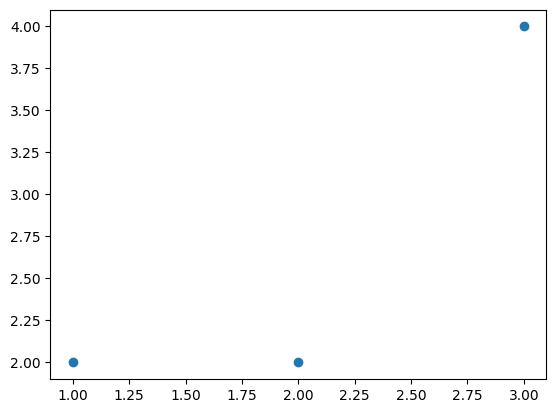

In [60]:
# Make a simple scatterplot
x_train = np.array([1,2,3])
y_train = np.array([2,2,4])
plt.scatter(x_train, y_train);
print(x_train.shape, y_train.shape)

<Axes: title={'center': 'Nice Plot'}, xlabel='$x$', ylabel='$x$'>

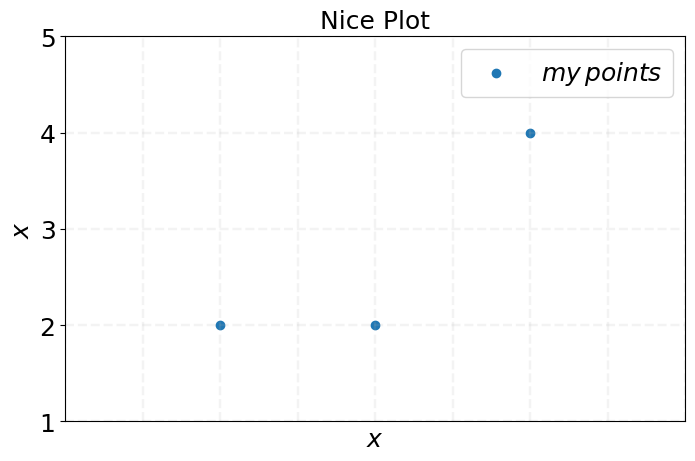

In [61]:
def nice_scatterplot(x, y, title):
    f_size = 18

    fig, ax = plt.subplots(1, 1, figsize=(8,5))

    ax.set_xlim(np.min(x)-1, np.max(x)+1)
    ax.set_ylim(np.min(y)-1, np.max(y)+1)

    ax.tick_params(labelsize=f_size)

    # Adjust size of tickmarks in axes
    ax.tick_params(labelsize=f_size)

    # Remove tick labels
    ax.tick_params(labelbottom=False, bottom=False)

    # Adjust size of axis label
    ax.set_xlabel(r"$x$", fontsize = f_size)
    ax.set_ylabel(r"$x$", fontsize = f_size)

    ax.set_title(title, fontsize=f_size)

    ax.grid(True, lw=1.75, ls="--", alpha=0.15)

    ax.scatter(x, y, label=r'$my\,points$')
    ax.legend(loc="best", fontsize=f_size);

    return ax

nice_scatterplot(x_train, y_train, "Nice Plot")

## Formulae

Linear regression is special among the models we study because it can be solved explicitly. While mode other models (and even some advanced versions of linear regression) must be solved iteratively, linear regression has a formula where you can simply plug in the data.

## Building a model from scratch

We have to reshape our arrays to 2D. We will see later why. In the meantime, let's:
* make an array with shape (2,3)
* reshape it to a size that you want

In [62]:
xx = np.array([[1,2,3], [4,6,8]])
print(f"Old shape: {xx.shape}")
xxx = xx.reshape(-1,2)
print(f"New shape: {xxx.shape}")

Old shape: (2, 3)
New shape: (3, 2)


In [63]:
# Reshape to be a proper 2D array
x_train = x_train.reshape(x_train.shape[0], 1)
y_train = y_train.reshape(y_train.shape[0], 1)

print(x_train.shape)
print(y_train.shape)

(3, 1)
(3, 1)


In [64]:
y_bar = np.mean(y_train)
x_bar = np.mean(x_train)

numerator = np.sum((x_train - x_bar) * (y_train - y_bar))
denominator = np.sum((x_train - x_bar)**2)

print(numerator.shape, denominator.shape)

() ()


Why the empty brackets? Well, this indicates that the numerator and denominator are scalars, as expected.

In [65]:
# Slope beta1
beta_1 = numerator/denominator

# Intercept beta0
beta_0 = y_bar - beta_1*x_bar

print("The best-fit line is {0:3.2f} + {1:3.2f} * x".format(beta_0, beta_1))
print(f'The best fit is {beta_0}')

The best-fit line is 0.67 + 1.00 * x
The best fit is 0.6666666666666665


Here's another exercise:

Turn the code from the above cells into a function called `simple_linear_regression_fit`, that inputs the training data and returns `beta0` and `beta1`.

In [66]:
def simple_linear_regression_fit(x_train: np.ndarray, y_train: np.ndarray) -> np.ndarray:
    """
    Inputs:
    x_train: a (num observations by 1) array holding the values of the predictor variable
    y_train: a (num observations by 1) array holding the values of the response variable

    Returns:
    beta_vals:  a (num_features by 1) array holding the intercept and slope coeficients
    """

    if len(x_train.shape) < 2:
        print("Reshaping features array...")
        x_train = x_train.reshape(x_train.shape[0], 1)

    if len(y_train.shape) < 2:
        print("Reshaping observations array...")
        y_train = y_train.reshape(y_train.shape[0], 1)
    
    # First, compute means
    y_bar = np.mean(y_train)
    x_bar = np.mean(x_train)

    # Build the two terms
    numerator = np.sum((x_train - x_bar) * (y_train - y_bar))
    denominator = np.sum((x_train - x_bar)**2)

    # Slope: beta_1
    beta_1 = numerator / denominator

    # Intercept: beta_0
    beta_0 = y_bar - beta_1*x_bar

    return np.array([beta_0, beta_1])

Let's run this function and see the coefficients:

In [67]:
x_train = np.array([1, 2, 3])
y_train = np.array([2, 2, 4])

betas = simple_linear_regression_fit(x_train, y_train)

beta_0 = betas[0]
beta_1 = betas[1]

print("The best-fit line is {0:8.6f} + {1:8.6f} * x".format(beta_0, beta_1))

Reshaping features array...
Reshaping observations array...
The best-fit line is 0.666667 + 1.000000 * x


Here's another exercise for our manually created model:
* Do the values of `beta0` and `beta1` seem reasonable?
* Plot the training data using a scatter plot.
* Plot the best fit line with `beta0` and `beta1` together with the training data.

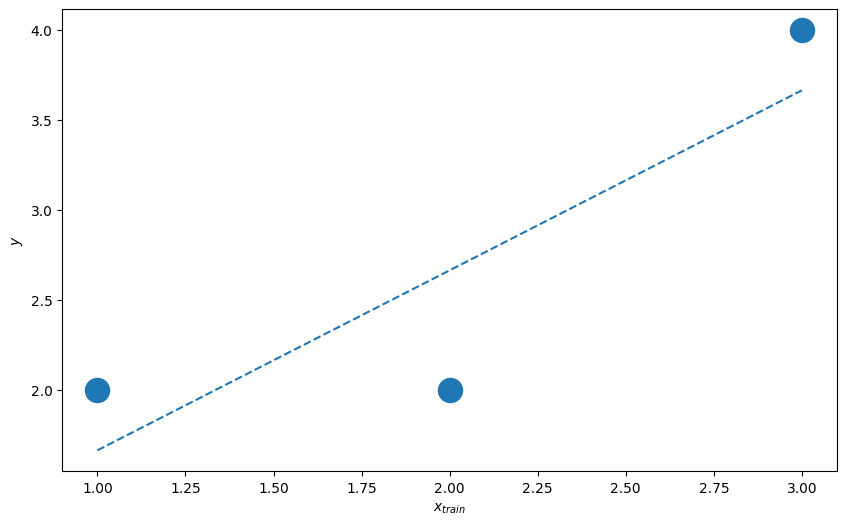

In [68]:
fig, ax_scat = plt.subplots(1, 1, figsize=(10,6))

# Plot best-fit line
x_train = np.array([[1, 2, 3]]).T

best_fit = beta_0 + beta_1 * x_train

ax_scat.scatter(x_train, y_train, s=300, label="Training Data")
ax_scat.plot(x_train, best_fit, ls="--", label="Best Fit Line")

ax_scat.set_xlabel(r'$x_{train}$')
ax_scat.set_ylabel(r'$y$');

The values of `beta0` and `beta1` seem roughly reasonable. They capture the positive correlation. The line does appear to be trying to get as close as possible to all the points.

# Building a model with `statsmodels` and `sklearn`

Our goal is to show how to implement simple linear regression with the above packages. For an important sanity check, we compare the beta values from `statsmodels` and `sklearn` to the beta values that we found from above with our own implementation.

For the purpose of this lab, `statsmodels` and `sklearn` do the same thing. More generally though, `statsmodels` tends to be easier for inference (findig the values of the slope an intercept and discussing the uncertainty in those values), whereas `sklearn` has ML algorithms and is better for prediction. Note that both packages make the same guesses, it's just a question of which activity they provide more support for.

Below is the code for `statsmodels.Statsmodfels`, which **does not include the column of ones in the X matrix**, so we include it manually with `sm.add_constant`.

In [69]:
import statsmodels.api as sm

In [71]:
X = sm.add_constant(x_train)

print(X)

toyregr_sm = sm.OLS(y_train, X)

results_sm = toyregr_sm.fit()

beta0_sm = results_sm.params[0]
beta1_sm = results_sm.params[1]

print(f"The regression coefficients from the stasmodels package are beta_0 = {beta0_sm:.2f} and beta_1 = {beta1_sm:.2f}")

[[1. 1.]
 [1. 2.]
 [1. 3.]]
The regression coefficients from the stasmodels package are beta_0 = 0.67 and beta_1 = 1.00


Besides the beta parameters, `results_sm` contains a ton of other potentially useful information.

In [72]:
print(results_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     3.000
Date:                Thu, 27 Nov 2025   Prob (F-statistic):              0.333
Time:                        12:08:57   Log-Likelihood:                -2.0007
No. Observations:                   3   AIC:                             8.001
Df Residuals:                       1   BIC:                             6.199
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667      1.247      0.535      0.6

Now let's turn our attention to the `sklearn` library.

In [73]:
from sklearn import linear_model

In [75]:
toyregr = linear_model.LinearRegression()

results = toyregr.fit(x_train, y_train)

beta0_skl = toyregr.intercept_
beta1_skl = toyregr.coef_[0]

print(f"The regression coefficients from the sklearn package are beta_0 = {beta0_skl:.2f} and beta_1 = {beta1_skl:.2f}")

The regression coefficients from the sklearn package are beta_0 = 0.67 and beta_1 = 1.00


Now it's time to move on to a real problem!

# The shape of things in `scikit-learn`

Before diving into a "real" problem, we really ought to discuss more of the details of `sklearn`. Along the way, we'll import the real-world dataset.

`scikit-learn` is the main Python ML library. It consists of many learners which can learn models from data, as well as a lot of utility functions such as `train_test_split`.

In `scikit-learn`, an **estimator** is a Python object that implements the methods `fit(X, y)` and `predict(T)`.

Let's see the structure of `scikit-learn` needed to make these fits. `.fit` always takes two arguments:

`estimator.fit(Xtrain, ytrain)`

We will consider two estimators in this lab: `LinearRegression` and `KNeighborsRegressor`.

**Critically, `Xtrain` must be in the form of an array of arrays (or a 2x2 array)** with the inner arrays each corresponding to one sample, and whose elements correspond to the feature values for that sample.

`ytain` on the other hand is a simple array of responses. These are continuous for regression problems.

## Practice with `sklearn`

We begin by leading up the `mtcars` dataset and cleaning it up a little bit:

In [76]:
import pandas as pd

dfcars = pd.read_csv("../data/mtcars.csv")
dfcars = dfcars.rename(columns={"Unnamed: 0":"car name"})
dfcars.head()

,car name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


Next, let's split the dataset into a training set and test set.

In [77]:
from sklearn.model_selection import train_test_split

traindf, testdf = train_test_split(dfcars, test_size=0.2, random_state=42)

In [78]:
print("Shape of full dataset is: {0}".format(dfcars.shape))
print("Shape of training dataset is: {0}".format(traindf.shape))
print("Shape of test dataset is: {0}".format(testdf.shape))

Shape of full dataset is: (32, 12)
Shape of training dataset is: (25, 12)
Shape of test dataset is: (7, 12)


Notice the shape of `y_train`:

In [79]:
np.shape(y_train)

(3,)

In [ ]:
# Same result with the method you're more used to
y_train.shape

(3,)

Now we have training and test data. We still need to select a predictor and a response from this dataset. Keep in mind that we need to choose the predictor and response from both the training and test set.

In [81]:
y_train = traindf.mpg
np.shape(y_train)

(25,)

This is not an "array of arrays". That's okay! Remember, `sklearn` requires an arrays of arrays only for the predictor array? You will have to pay close attention to this in the exercises later.

For now, let's discuss two ways out of this debacle. All we'll do it get `y_train` to be an array of arrays. This doesn't hurt anything because `sklearn` doesn't care too much about the shape of `y_train`.

First, let's reshape `y_train` to be an array of arrays using the `reshape` method. We want the first dimension of `y_train` to be size 25 and the second dimension to be size 1.

In [88]:
y_train_reshape = y_train.values.reshape(y_train.shape[0], 1)
print(f"y_train shape: {y_train.shape}")
print(f"y_train_reshape shape: {y_train_reshape.shape}")

y_train shape: (25,)
y_train_reshape shape: (25, 1)


Notice that `y_train.shape[0]` gives the size of the first dimension.

There's an even easier way to get the correct shape right from the beginning.

In [89]:
y_train_reshape = traindf[["mpg"]]
y_train_reshape.shape

(25, 1)

Finally, there's a nice shortcut for reshaping an array. `numpy` can infer a dimension based on the other dimensions specified.

In [90]:
y_train_reshape = y_train.values.reshape(-1, 1)
y_train_reshape.shape

(25, 1)

In this case, we said the second dimension should be size 1. Since the requirement of the `reshape()` method is that the requested dimensions be compatible, `numpy` decides that the first dimension must be size 25.

Let's see what the shape would return if we switched it up a bit:

In [95]:
test = y_train.values.reshape(-1,5)
test.shape

(5, 5)

Now you know how to reshape your data into the correct format. Yay!

**Important:** Remember that your response variable `ytrain` can be a vector but your predictor variable `xtrain` **must** be an array!

## Simple linear regression with automobile data

We will now use `sklearn` to predict automobile mpg and evaluate these predictions. We already loaded the data and split them into a training and test set.

We need to choose the variables that we think will be good predictors for the dependent variable `mpg`.

### Exercise

* Pick one variable to use as a predictor for simple linear regression. Create a markdown cell below and discuss your reasons.
* Justify your choice with some visualizations.
* Is there a second variable you'd like to use? For example, we're not doing multiple linear regression here, but if we were, is there another variable you'd like to include if we were using two predictors?

In [96]:
dfcars.columns

Index(['car name', 'mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb'], dtype='object')

I'll just use `hp` as a predictor:

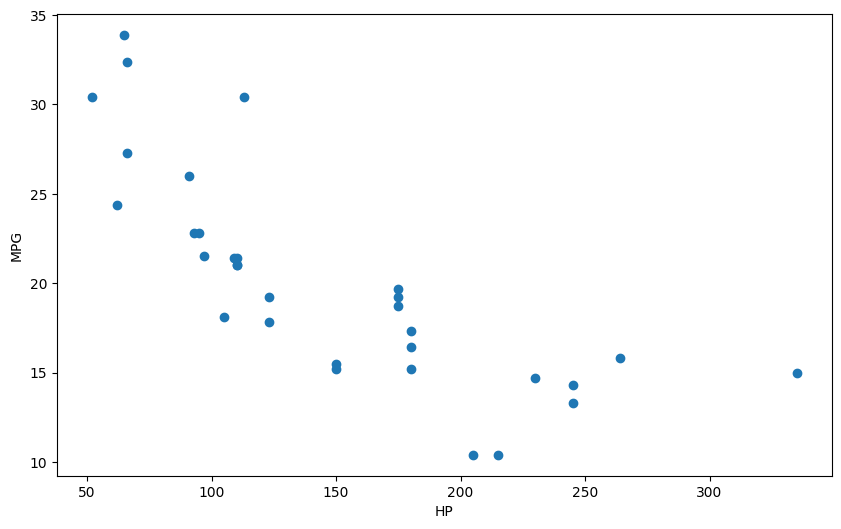

In [111]:
y_mpg = dfcars.mpg
x_hp = dfcars.hp

fig_hp, ax_hp = plt.subplots(1,1, figsize=(10,6))
ax_hp.scatter(x_hp, y_mpg)
ax_hp.set_xlabel("HP")
ax_hp.set_ylabel("MPG")
plt.show()


There does seem to be a somewhat linear relationship between `hp` and `mpg`.

## Exercise

* Use `sklearn` to fit the training data using simple linear regression.
* Use the model to make mpg predictions on the test set.
* Plot the data and the prediction.
* Print out the mean squared error for the training set and the test set and compare.

In [113]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [117]:
traindf, test_df = train_test_split(dfcars, test_size=0.2, random_state=42)
y_train = np.array(traindf.mpg)
X_train = np.array(traindf.wt)
X_train = X_train.reshape(-1, 1)
print(X_train.shape)
print(y_train.shape)

(25, 1)
(25,)


In [118]:
y_test = np.array(testdf.mpg)
X_test = np.array(testdf.wt)
X_test = X_test.reshape(-1, 1)
print(X_test.shape)
print(y_test.shape)


(7, 1)
(7,)


In [119]:
regression = LinearRegression()
regression.fit(X_train, y_train)
predicted_y = regression.predict(X_test)

r2 = regression.score(X_test, y_test)
print(r2)

0.6879761857596275


In [126]:
print("Train r2 score: ", regression.score(X_train, y_train))
print("Train MSE: ", mean_squared_error(y_train, regression.predict(X_train)))
print("Test MSE: ", mean_squared_error(predicted_y, y_test))
print("Coefficient and Intercept", regression.coef_, regression.intercept_)

Train r2 score:  0.7701379909791617
Train MSE:  7.773697766387515
Test MSE:  12.475985659918825
Coefficient and Intercept [-5.3369414] 36.93731031351841


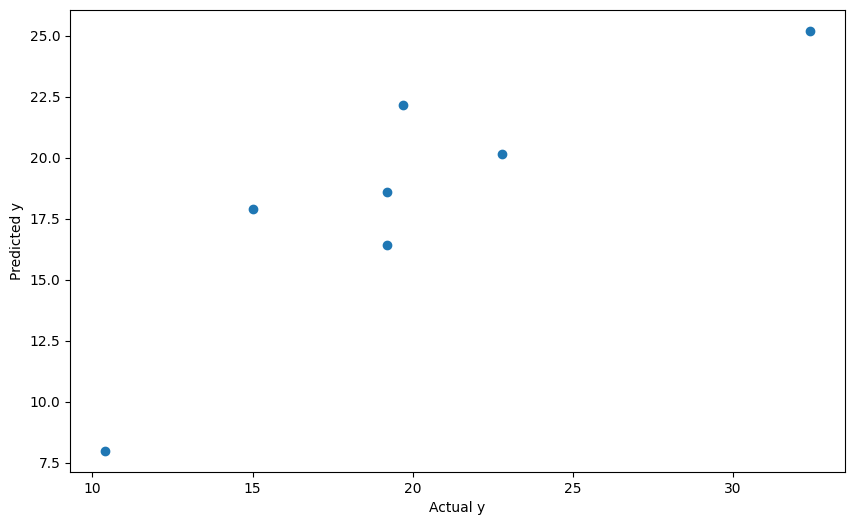

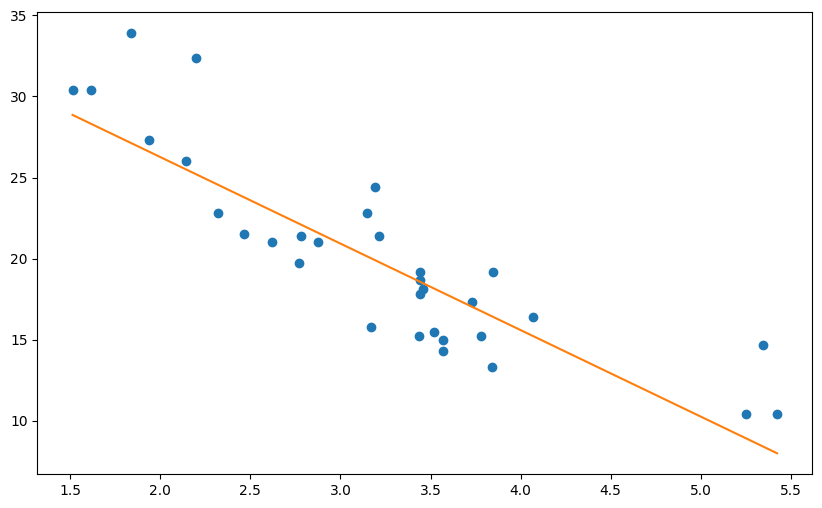

In [130]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(y_test, predicted_y, "o")
grid = np.linspace(np.min(dfcars.mpg), np.max(dfcars.mpg), 100)
ax.set_xlabel("Actual y")
ax.set_ylabel("Predicted y")

fig1, ax1 = plt.subplots(1,1, figsize=(10,6))
ax1.plot(dfcars.wt, dfcars.mpg, 'o')
xgrid = np.linspace(np.min(dfcars.wt), np.max(dfcars.wt), 100)
ax1.plot(xgrid, regression.predict(xgrid.reshape(100, 1)))
